# TUTORIAL : Incompressible Navier-Stokes

In [1]:
using Gridap
using GridapMakie, GLMakie

In [2]:
n = 100
domain = (0,1,0,1)
partition = (n,n)

(100, 100)

In [3]:
model = CartesianDiscreteModel(domain,partition)

CartesianDiscreteModel()

In [4]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"diri1",[6,])
add_tag_from_tags!(labels,"diri0",[1,2,3,4,5,7,8])

12-element Vector{String}:
 "tag_1"
 "tag_2"
 "tag_3"
 "tag_4"
 "tag_5"
 "tag_6"
 "tag_7"
 "tag_8"
 "interior"
 "boundary"
 "diri1"
 "diri0"

In [5]:
D = 2
order = 2
reffeᵤ = ReferenceFE(lagrangian,VectorValue{2,Float64},order)


(Lagrangian(), (VectorValue{2, Float64}, 2), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [6]:
V = TestFESpace(model,reffeᵤ,conformity=:H1 ,dirichlet_tags=["diri0","diri1"])

UnconstrainedFESpace()

In [7]:
degree = order
Ωₕ = Triangulation(model)
dΩ = Measure(Ωₕ,degree)

Measure()

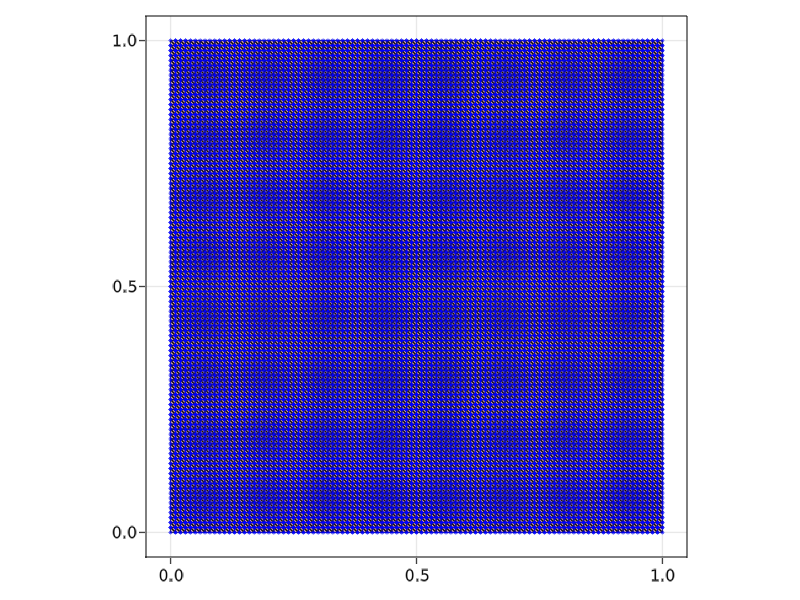

In [8]:
fig, ax = plot(Ωₕ)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ωₕ, color=:black, linewidth=1)
scatter!(Ωₕ, marker=:star8, markersize=4, color=:blue)
fig

In [9]:
reffeₚ = ReferenceFE(lagrangian,Float64,order-1;space=:P)
Q = TestFESpace(model,reffeₚ,conformity=:L2,constraint=:zeromean)

ZeroMeanFESpace()

In [10]:
uD0 = VectorValue(0,0)
uD1 = VectorValue(1,0)
U = TrialFESpace(V,[uD0,uD1])
P = TrialFESpace(Q)

Y = MultiFieldFESpace([V, Q])
X = MultiFieldFESpace([U, P])

MultiFieldFESpace()

In [11]:
const Re = 10.0
conv(u,∇u) = Re*(∇u')⋅u
dconv(du,∇du,u,∇u) = conv(u,∇du)+conv(du,∇u)

dconv (generic function with 1 method)

In [12]:
a((u,p),(v,q)) = ∫( ∇(v)⊙∇(u) - (∇⋅v)*p + q*(∇⋅u) )dΩ


a (generic function with 1 method)

In [13]:
c(u,v) = ∫( v⊙(conv∘(u,∇(u))) )dΩ
dc(u,du,v) = ∫( v⊙(dconv∘(du,∇(du),u,∇(u))) )dΩ

dc (generic function with 1 method)

In [14]:
res((u,p),(v,q)) = a((u,p),(v,q)) + c(u,v)
jac((u,p),(du,dp),(v,q)) = a((du,dp),(v,q)) + dc(u,du,v)

jac (generic function with 1 method)

In [15]:
op = FEOperator(res,jac,X,Y)


FEOperatorFromWeakForm()

In [16]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:newton, linesearch=BackTracking())
solver = FESolver(nls)

NonlinearFESolver()

In [17]:
uh, ph = solve(solver,op)


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.777778e+00              NaN
     1     5.380596e-03     2.950525e+09
     2     1.750609e-06     6.764194e+05
     3     1.601574e-12     3.525730e-01


MultiFieldFEFunction():
 num_cells: 10000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 15523260986081001174

In [18]:
writevtk(Ωₕ,"ins-results",cellfields=["uh"=>uh,"ph"=>ph])


(["ins-results.vtu"],)